In [1]:
import numpy as np
import pandas as pd
import os
from os import path
import matplotlib.pyplot as plt
import random
import copy
import ipython_bell

from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.visualization import make_lupton_rgb

import lenstronomy.Util.param_util as param
import lenstronomy.Util.util as util
from lenstronomy.SimulationAPI.sim_api import SimAPI

In [2]:
DES_camera = {'read_noise': 7.,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.2637,  # scale (in arcseconds) of pixels
               'ccd_gain': 6.  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 22.5, #35.01,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 7,  # number of exposures that are combined
                   'seeing': 1.12,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

DES_r_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 22.8, #34.7,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

DES_i_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 22.8, #35.1,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

numpix = 114#46 

kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)

kwargs_numerics = {'point_source_supersampling_factor': 10}

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)


In [3]:
def make_plot(image_g, image_r, image_i):
    rgb = make_lupton_rgb(np.log10(image_g), np.log10(image_r), np.log10(image_i), Q=2., stretch=4.)
    plt.figure()
    plt.imshow(rgb)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.show(block=True)
    

In [4]:
def simulation(redshifts, magnitude_lens, r_sersic, sigma, lens_ellip, i):
   
    kwargs_model_physical = {'lens_model_list': ['SIE'],  # list of lens models to be used
                          'lens_redshift_list': [redshifts['lens']],  # list of redshift of the deflections
                          'lens_light_model_list': ['SERSIC_ELLIPSE'],  
                          'cosmo': cosmo,  # astropy.cosmology instance
                          # redshift of the default source (if not further specified by 'source_redshift_list')
                          'z_source': redshifts['source1']
                            } 
        
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model_physical)
    sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model_physical)
    
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)
    imSim_i = sim_i.image_model_class(kwargs_numerics)

    #lens mass model
    kwargs_mass = [{'sigma_v': sigma, 'center_x': 0, 'center_y': 0, 
                    'e1': lens_ellip[0], 'e2': lens_ellip[1]}]
    #kwargs_lens = [sim_g.physical2lensing_conversion(kwargs_mass=kwargs_mass)[0], 
    #               {'gamma1': lens_ellip[0], 'gamma2': lens_ellip[1], 'ra_0': 0, 'dec_0': 0}]
    kwargs_lens = sim_g.physical2lensing_conversion(kwargs_mass=kwargs_mass)
    
    #lens light distribution
    m_lens_g, m_lens_r, m_lens_i = magnitude_lens['g'], magnitude_lens['r'], magnitude_lens['i']
    kwargs_lens_light_mag_g = [{'magnitude': m_lens_g, 'R_sersic': r_sersic['g'], 'n_sersic': 2, 
                                'e1': lens_ellip[0], 'e2': lens_ellip[1], 'center_x': 0, 'center_y': 0}]
    
    #First source light distributions & colors of the other bands for each source
    kwargs_source_mag_g = [{'magnitude': 80, 'R_sersic': 0.5, 'n_sersic': 1.3, 'e1': 0., 'e2': 0.,
                              'center_x': 0, 'center_y': 0}]
    #Adding color distribution to the bands (lens):
    kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
    kwargs_lens_light_mag_r[0]['magnitude'], kwargs_lens_light_mag_r[0]['R_sersic'] = m_lens_r, r_sersic['r']
    kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_r)
    kwargs_lens_light_mag_i[0]['magnitude'], kwargs_lens_light_mag_r[0]['R_sersic'] = m_lens_i, r_sersic['i']
    #Adding color distribution to the bands (first source):
    kwargs_source_mag_r, kwargs_source_mag_i= copy.deepcopy(kwargs_source_mag_g), copy.deepcopy(kwargs_source_mag_g)
        
    kwargs_lens_light_g, kwargs_source_g , point = sim_g.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_g, 
                                                    kwargs_source_mag=None, kwargs_ps_mag=None)
    kwargs_lens_light_r, kwargs_source_r , point = sim_r.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_r, 
                                                    kwargs_source_mag=None, kwargs_ps_mag=None)
    kwargs_lens_light_i, kwargs_source_i , point = sim_i.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_i, 
                                                    kwargs_source_mag=None, kwargs_ps_mag=None)
    
    image_g = imSim_g.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g)
    image_r = imSim_r.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r)
    image_i = imSim_i.image(kwargs_lens, kwargs_source_i, kwargs_lens_light_i)
    
    image_g += sim_g.noise_for_model(model=image_g)
    image_r += sim_r.noise_for_model(model=image_r)
    image_i += sim_i.noise_for_model(model=image_i)
    
    #image_g = image_g[::-1]
    #image_r = image_r[::-1]
    #image_i = image_i[::-1] 
    
    return(image_g, image_r, image_i)
    

In [5]:
path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/'
data_gal = pd.read_csv(path + 'tests/calibration/galaxies/galaxies_cal.csv')

data_stars = pd.read_csv(path + 'tests/calibration/stars/stars_cal.csv')
data_stars

,COADD_OBJECT_ID,MAG_PSF_G,MAG_PSF_R,MAG_PSF_I,MAG_APER_8_G,MAG_APER_8_R,MAG_APER_8_I,FLUX_RADIUS_G,FLUX_RADIUS_R,FLUX_RADIUS_I,DNF_ZMEAN_SOF,SOF_CM_G_1,SOF_CM_G_2
0,172094624,19.999313,18.658159,18.234085,19.905287,18.662622,18.207388,2.770754,2.316952,2.226163,0.317892,-0.134499,0.189864
1,165893479,20.000347,19.050272,18.762819,19.990898,19.076296,18.775764,2.718349,2.610414,2.414583,0.308640,-0.037916,-0.047919
2,166798323,20.000622,18.797222,18.298964,20.024775,18.792696,18.276772,2.637595,2.410505,2.145144,0.292758,-0.559173,0.022965
3,458858495,19.999874,19.486450,19.415823,20.191446,19.713404,19.555655,2.143429,1.845013,1.775391,0.148330,0.002771,0.012152
4,169278801,20.000324,19.403820,19.225712,19.980654,19.397509,19.236053,2.642065,2.110090,2.110335,0.198441,-0.069347,-0.061529
5,168972899,20.000828,18.453266,16.847279,20.001699,18.453161,16.848789,3.164946,2.303748,2.217369,4.405808,-9999.000000,-9999.000000
6,458753232,20.000673,18.558664,17.746809,19.986862,18.529219,17.710768,2.560404,2.435941,2.244666,0.384306,-0.169011,0.250522
7,459159000,19.999565,18.532461,17.582233,20.011915,18.527170,17.578091,2.348826,2.263424,2.062531,4.405808,-9999.000000,-9999.000000
8,461063985,20.000044,19.285328,19.016537,20.008179,19.281128,19.031883,2.537541,2.314456,2.106323,0.208020,0.029130,-0.094447
9,460015748,19.999512,19.652533,19.559017,19.989265,19.671007,19.589119,2.609459,2.090301,2.038137,0.099029,-0.056003,0.055764


In [6]:
def simulations_from_data(filename):
    x = np.zeros((1,3,numpix,numpix))
    data = pd.read_csv(filename)
    for index, row in data.iterrows():
        
        coadd_id = int(row['COADD_OBJECT_ID'])
        z_lens = row['DNF_ZMEAN_SOF']
        z_source1 = random.uniform(z_lens + 0.3, z_lens + 0.4) # 0.35, 0.7
        redshifts = {'lens': z_lens, 'source1': z_source1}
        magnitude_lens = {'g': row['MAG_PSF_G'], 'r': row['MAG_PSF_R'], 'i': row['MAG_PSF_I']}
        dispersion = 200
        r_sersic = {'g': row['FLUX_RADIUS_G']*0.2637, 'r': row['FLUX_RADIUS_R']*0.2637, 'i': row['FLUX_RADIUS_I']*0.2637}
        
        angle, ratio = param.ellipticity2phi_q(row['SOF_CM_G_1'], row['SOF_CM_G_2'])
        if(row['SOF_CM_G_1'] < -100): 
            angle = 0
            ratio = 1
        e1, e2 = param.phi_q2_ellipticity(angle, ratio)
        lens_ellip = [e1, e2]
    
        image_g, image_r, image_i = simulation(redshifts, magnitude_lens, r_sersic, dispersion, lens_ellip, coadd_id)
        #make_plot(image_g, image_r, image_i)
        
        ele_sim = np.array([image_g, image_r , image_i])
        x = np.append(x, [ele_sim], axis = 0)
        
    x = np.delete(x, 0, axis = 0)
    return(x)


In [7]:
filename = path + 'tests/calibration/galaxies/galaxies_cal.csv'
galaxies_sim = simulations_from_data(filename)

filename = path + 'tests/calibration/stars/stars_cal.csv'
stars_sim = simulations_from_data(filename)

In [8]:
def cutouts(filename, data):
    x = np.zeros((1,3,114,114))
    ids = data['COADD_OBJECT_ID']
    for id in ids:
        new_name = filename + str(id)
        with fits.open(new_name + '_g.fits') as hdul: img_g = hdul[0].data
        with fits.open(new_name + '_i.fits') as hdul: img_i = hdul[0].data
        with fits.open(new_name + '_r.fits') as hdul: img_r = hdul[0].data
        ele_sim = np.array([img_g, img_r , img_i])
        x = np.append(x, [ele_sim], axis = 0)
    x = np.delete(x, 0, axis = 0)
    return(x)

In [9]:
filename = path + 'tests/calibration/galaxies/galaxies_cutouts/'
galaxies_real = cutouts(filename, data_gal)

filename = path + 'tests/calibration/stars/stars_cutouts/'
stars_real = cutouts(filename, data_stars)

In [10]:
def calculate_flux(object, band):
    flux = np.sum(object[band])
    return(flux)

In [11]:
#g,r,i -> i,r,g
def make_plot_all(objects):
    plt.figure(figsize=(15,10))
    for i in range(10):
        fl = calculate_flux(objects[i], 0)
        plt.subplot(1,10,i+1)
        plt.title('F = {:.0f}'.format(fl))
        rgb = make_lupton_rgb(objects[i][2], objects[i][1], objects[i][0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.xticks([], [])
        plt.yticks([], [])
    plt.show()
    

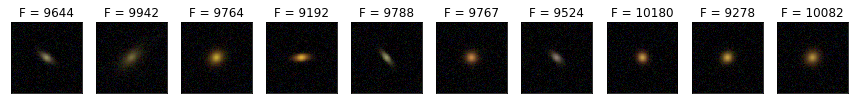

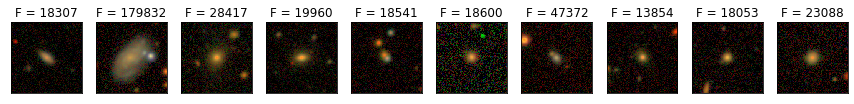

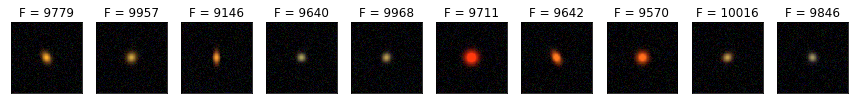

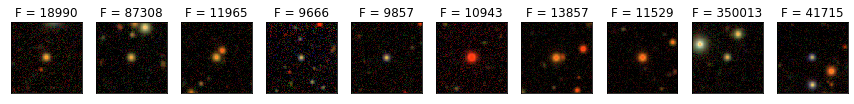

In [12]:
make_plot_all(galaxies_sim)
make_plot_all(galaxies_real)
make_plot_all(stars_sim)
make_plot_all(stars_real)

In [13]:
def crop_image(object, c):
    i, f = int(numpix/2 - c/2), int(numpix/2 + c/2)
    object_g, object_r, object_i = object[0][i:f], object[1][i:f], object[2][i:f]
    crop_g, crop_r, crop_i = np.zeros((1,c)), np.zeros((1,c)), np.zeros((1,c))
    for j in range(c):
        crop_g = np.append(crop_g, [object_g[j][i:f]], axis = 0)
        crop_r = np.append(crop_r, [object_r[j][i:f]], axis = 0)
        crop_i = np.append(crop_i, [object_i[j][i:f]], axis = 0)
    crop_g, crop_r, crop_i = np.delete(crop_g, 0, axis = 0), np.delete(crop_r, 0, axis = 0), np.delete(crop_i, 0, axis = 0)
    ele_sim = np.array([crop_g, crop_r, crop_i])
    return(ele_sim)


In [14]:
def crop_all(objects, c):
    x = np.zeros((1,3,c,c))
    for object in objects:
        new_object = crop_image(object, c)
        ele_sim = np.array([new_object[0], new_object[1], new_object[2]])
        x = np.append(x, [ele_sim], axis = 0)
    x = np.delete(x, 0, axis = 0)
    return(x)

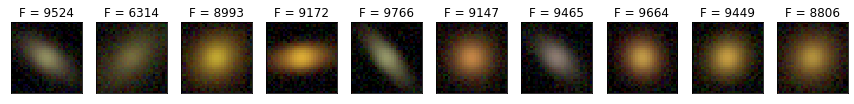

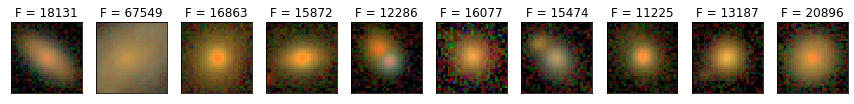

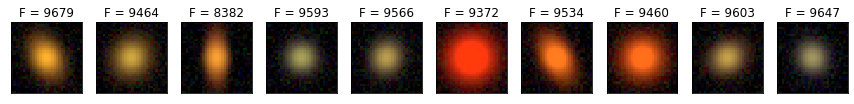

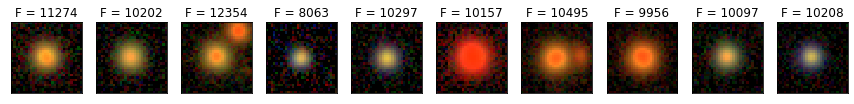

In [15]:
c = 30
galaxies_sim_crop = crop_all(galaxies_sim, c)
galaxies_real_crop = crop_all(galaxies_real, c)
stars_sim_crop = crop_all(stars_sim, c)
stars_real_crop = crop_all(stars_real, c)

make_plot_all(galaxies_sim_crop)
make_plot_all(galaxies_real_crop)
make_plot_all(stars_sim_crop)
make_plot_all(stars_real_crop)

In [16]:
def apparent_magnitude(object, band):
    f = calculate_flux(object, band)
    m = -2.5*np.log10(f*10**(-12))
    return(m)

In [17]:
app_mag, error = [], []
for i in range(len(galaxies_sim)):
    m = apparent_magnitude(galaxies_sim[i], 0)
    m_t = data_gal['MAG_PSF_G'][i]
    e = np.abs(m - m_t)*100/m_t
    app_mag.append(m)
    error.append(e)
data_gal['Mag_cal'] = app_mag
data_gal['Error'] = error
data_gal.loc[:, ['MAG_PSF_G','MAG_APER_8_G','Mag_cal', 'Error']]

,MAG_PSF_G,MAG_APER_8_G,Mag_cal,Error
0,20.000189,19.454721,20.039412,0.196112
1,20.000381,18.509636,20.006333,0.029758
2,20.000412,19.613064,20.025913,0.127500
3,20.000147,19.607409,20.091440,0.456462
4,19.999437,19.816130,20.023250,0.119067
5,20.000784,19.562481,20.025641,0.124281
6,20.000414,19.613028,20.052941,0.262629
7,20.000954,19.955053,19.980624,0.101646
8,20.000830,19.756779,20.081351,0.402590
9,20.000364,19.308926,19.991144,0.046099


In [18]:
app_mag, error = [], []
for i in range(len(stars_sim)):
    m = apparent_magnitude(stars_sim[i], 0)
    m_t = data_stars['MAG_PSF_G'][i]
    e = np.abs(m - m_t)*100/m_t
    app_mag.append(m)
    error.append(e)
data_stars['Mag_cal'] = app_mag
data_stars['Error'] = error
data_stars.loc[:, ['MAG_PSF_G','MAG_APER_8_G','Mag_cal', 'Error']]

,MAG_PSF_G,MAG_APER_8_G,Mag_cal,Error
0,19.999313,19.905287,20.024250,0.124686
1,20.000347,19.990898,20.004730,0.021914
2,20.000622,20.024775,20.096922,0.481487
3,19.999874,20.191446,20.039805,0.199657
4,20.000324,19.980654,20.003476,0.015760
5,20.000828,20.001699,20.031865,0.155182
6,20.000673,19.986862,20.039544,0.194349
7,19.999565,20.011915,20.047753,0.240946
8,20.000044,20.008179,19.998275,0.008846
9,19.999512,19.989265,20.016868,0.086785
